In [1]:
%matplotlib inline

import numpy as np
from numpy import linalg as nla
import scipy as sp
from scipy import linalg as sla
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pprint import pprint
from time import time
import os

from jupyterthemes import jtplot
jtplot.style(theme='solarizedl')

from IPython.core.display import display, HTML
np.set_printoptions(linewidth = 270)

In [2]:
def NewtonPoly(A, X0 = np.NAN, maxiter = 100, tol = np.NAN, cls = 'Pure', LS_iter = 2):
    if np.sum(np.isnan(X0)) > 0: # X0가 주어지지 않았을 때 m by m zero 행렬 처리
        X0 = np.zeros((A.shape[1],A.shape[2]))
    
    if A.shape[1] != A.shape[2]: # A가 square matrices의 모음이 아닐 때 예외처리
        raise ValueError('A가 정방행렬이 아닙니다.')
        
    m, n = A.shape[1], A.shape[0]-1 # m, n 초기화
    
    if np.isnan(tol): # tol이 주어지지 않았을 때 초기화
        tol = m * 1e-15
        
    Xs = [X0] # Xs는 X들을 담은 리스트로 초기화
    P_Xs, Hs, errs = [], [], [] # P_X, H, err 리스트 초기화
    S = np.zeros((A.shape[1],A.shape[2]))
    
    iter = 0
    err = 1e10 # error 초기화
    L = []
    
    # Newton Iteration 시작
    c_time = time()
    while (err > tol) and (iter < maxiter):
        P_X = np.zeros((m**2, m**2))
        for k in range(1,n+1):
            for l in range(k):
                P_X = P_X + np.kron(nla.matrix_power(X0.transpose(),k-l-1), A[k,:,:] @ nla.matrix_power(X0, l))
        P_Xs.append(P_X) # P_X_i 저장
        vP = np.reshape(Pnomial(X0, A), m**2, 'F') # Reshape는 반드시 Fortran 방식으로
        h = nla.solve(P_X, vP)
#         h = nla.lstsq(P_X, vP)[0]
        H = np.reshape(h, (m, m), order = 'F')
        
        if cls == 'Pure':
            X0 = X0 - H # Newton Sequence 적용
            err = nla.norm(Pnomial(X0, A), 'fro') # err 계산
            
            Xs.append(X0) # X_i 저장
            Hs.append(H) # H_i 저장
            errs.append(err) # err 저장
        
        elif cls == 'Modified':
            X0 = X0 - 2*H # modified Newton Sequence 적용
            err = nla.norm(Pnomial(X0, A), 'fro') # err 계산
            if err <= tol:
                Xs.append(X0) # X_i 저장
                Hs.append(H) # H_i 저장
                errs.append(err) # err 저장
                break
            X0 = X0 + H # pure Newton 재적용
            err = nla.norm(Pnomial(X0, A), 'fro') # err 계산
            
            Xs.append(X0) # X_i 저장
            Hs.append(H) # H_i 저장
            errs.append(err) # err 저장
            
        elif cls == 'MLSearch':
            if iter != LS_iter:
                X0 = X0 - H # Newton Sequence 적용
                err = nla.norm(Pnomial(X0, A), 'fro') # err 계산
                L.append(1)
            else:
                pt = np.zeros(2*n + 1)
                for t in range(2*n + 1):
                    pt[t] = CoeffiLSearch(A, X0, -H, t)
                pt = np.flip(pt)
                pt = pt/np.min(np.abs(pt))
                ptder = np.polyder(pt)
                critic = np.roots(ptder)
                val = np.polyval(pt, critic)
                val = np.where(np.logical_and(critic >= 1, critic <= 2), val, np.infty)
                if np.sum(np.isinf(val)) == len(val):
                    lamb = 1
                else:
                    lamb = np.real(critic[np.argmin(np.abs(val))])
                L.append(lamb)
                print(pt, critic, val, lamb)
                
                X0 = X0 - lamb * H # Newton Line Search 적용
                err = nla.norm(Pnomial(X0, A), 'fro') # err 계산
                
            if err <= tol:
                Xs.append(X0) # X_i 저장
                Hs.append(H) # H_i 저장
                errs.append(err) # err 저장
                break
            
            Xs.append(X0) # X_i 저장
            Hs.append(H) # H_i 저장
            errs.append(err) # err 저장
            
        else:
            print('준비되지 않은 종류의 Newton method라 pure method로 전환합니다.')
            iter -= 1
            cls = 'Pure'
            
        iter += 1
    c_time = time() - c_time
    S = Xs[-1] # Solution
    
    # Vectorize of S - X_{i}와 X_{i+1} - X_{i} : cos 계산
    vSmX = []
    vXmX = []
    for i in range(len(Xs)-1):
        vSmX.append(np.reshape(S - Xs[i], S.shape[0]*S.shape[1], order='F'))
        vXmX.append(np.reshape(Xs[i+1] - Xs[i], S.shape[0]*S.shape[1], order='F'))
    cSX = []
    cXX = []
    for i in range(len(vSmX)-1):
        x1, y1 = vSmX[i+1], vSmX[i]
        x2, y2 = vXmX[i+1], vXmX[i]
        c1 = np.dot(x1,y1) / (nla.norm(x1,2)*nla.norm(y1,2))
        c2 = np.dot(x2,y2) / (nla.norm(x2,2)*nla.norm(y2,2))
        cSX.append(c1)
        cXX.append(c2)
    return {'sol':S, 'Xs':Xs, 'P_Xs':P_Xs, 'Hs':Hs, 'errs':errs, 'SmX':vSmX, 'XmX':vXmX, 'csSmX':cSX, 'csXmX':cXX, 'CalTime':c_time, 'lamb':L}

def CoeffiLSearch(A, X, H, jq):
    n = A.shape[0]-1
    S = np.zeros(X.shape)
    for p in range(n+1):
        for k in range(n+1):
            for q in range(p+1):
                for j in range(k+1):
                    if j+q == jq:
                        S = S + PHIX(X.transpose(), H.transpose(), p, q) @ A[p,:,:].transpose() @ A[k,:,:] @ PHIX(X, H, k, j)
    return np.trace(S)

def PHIX(X, H, k, j):
    if k == 0:
        S = np.eye(X.shape[0])
    else:
        L = []
        phi = [X, H]
        S = np.zeros(X.shape)
        P = np.eye(X.shape[0])
        for p in range(2**k):
            L.append(("{:{fill}"+str(k)+"b}").format(p, fill="0"))
        L = [[int(l) for l in ll] for ll in L]
        for l in L:
            if sum(l) == j:
                for i in l:
                    P = P @ phi[i]
                S = S + P
                P = np.eye(X.shape[0])
    return S

def Pnomial(X, A):
#     S = np.zeros((X.shape[0],X.shape[1]))
#     for k in range(A.shape[0]):
#         S = S + A[k,:,:] @ nla.matrix_power(X, k)
    Y = A[-1,:,:]
    for i in range(2, A.shape[0]+1):
        Y = A[-i,:,:] + Y @ X # 계산 수를 줄인 polynomial 계산 함수
    return Y

def MakeStochA(dim, degree = 1):
    A = np.random.rand(degree + 1, dim, dim)
    b = np.sum(A, axis = (0, 2))
    for i in range(degree +1):
        for j in range(dim):
            A[i,j,:] = A[i,j,:]/b[j]
    r = np.max(np.abs(nla.eigvals(np.sum(A,0))))
    
    for i in range(dim):
        A[1,i,i] = A[1,i,i] - r
        
    return A

def MakeSingularA(dim, degree, delta = 0):
    A = np.zeros((degree+1, dim, dim))
    K = np.random.rand(dim, dim)
    for i in range(dim):
        K[i,i] = 0
    k = np.sum(K, axis = 1)
    for j in range(dim):
        K[j,:] = K[j,:]/k[j]
    W = (1 - delta) * K
    
    if degree == 2:
        A[0,:,:] = W
        A[1,:,:] = W - 3*np.eye(dim)
        A[2,:,:] = W + 3*delta * np.eye(dim)
        A /= 3
    elif degree == 4:
        A[0,:,:] = 16*W
        A[1,:,:] = 2*W - 26*np.eye(dim)
        A[2,:,:] = W
        A[3,:,:] = 6*W
        A[4,:,:] = W + 26*delta * np.eye(dim)
        A /= 26
    elif degree == 6:
        A[0,:,:] = 4096*W
        A[1,:,:] = 56*W - 6200*np.eye(dim)
        A[2,:,:] = 384*W
        A[3,:,:] = 1312*W
        A[4,:,:] = 321*W
        A[5,:,:] = 30*W
        A[6,:,:] = W + 6200*delta * np.eye(dim)
        A /= 6200
    elif degree == 8:
        A[0,:,:] = 2985984*W
        A[1,:,:] = 21024*W - 4500000*np.eye(dim)
        A[2,:,:] = 311040*W
        A[3,:,:] = 905472*W
        A[4,:,:] = 244080*W
        A[5,:,:] = 30312*W
        A[6,:,:] = 2017*W
        A[7,:,:] = 70*W
        A[8,:,:] = W + 4500000*delta*np.eye(dim)
        A /= 4500000
    else:
        raise ValueError('degree 2, 4, 6, 8 외에는 준비되지 않았습니다.')
    return A

def MakeGenSingA(dim, degree, delta = 0):
    A = np.zeros((degree+1, dim, dim))
    
    if degree == 2:
        A[0,:,:] = genW(dim, delta)
        A[1,:,:] = genW(dim, delta) - 3*np.eye(dim)
        A[2,:,:] = genW(dim, delta) + 3*delta * np.eye(dim)
        A /= 3
    elif degree == 4:
        A[0,:,:] = 16*genW(dim, delta)
        A[1,:,:] = 2*genW(dim, delta) - 26*np.eye(dim)
        A[2,:,:] = genW(dim, delta)
        A[3,:,:] = 6*genW(dim, delta)
        A[4,:,:] = genW(dim, delta) + 26*delta * np.eye(dim)
        A /= 26
    elif degree == 6:
        A[0,:,:] = 4096*genW(dim, delta)
        A[1,:,:] = 56*genW(dim, delta) - 6200*np.eye(dim)
        A[2,:,:] = 384*genW(dim, delta)
        A[3,:,:] = 1312*genW(dim, delta)
        A[4,:,:] = 321*genW(dim, delta)
        A[5,:,:] = 30*genW(dim, delta)
        A[6,:,:] = genW(dim, delta) + 6200*delta * np.eye(dim)
        A /= 6200
    elif degree == 8:
        A[0,:,:] = 2985984*genW(dim, delta)
        A[1,:,:] = 21024*genW(dim, delta) - 4500000*np.eye(dim)
        A[2,:,:] = 311040*genW(dim, delta)
        A[3,:,:] = 905472*genW(dim, delta)
        A[4,:,:] = 244080*genW(dim, delta)
        A[5,:,:] = 30312*genW(dim, delta)
        A[6,:,:] = 2017*genW(dim, delta)
        A[7,:,:] = 70*genW(dim, delta)
        A[8,:,:] = genW(dim, delta) + 4500000*delta*np.eye(dim)
        A /= 4500000
    else:
        raise ValueError('degree 2, 4, 6, 8 외에는 준비되지 않았습니다.')
    return A

def genW(dim, delta = 0):
    K = np.random.rand(dim, dim)
    for i in range(dim):
        K[i,i] = 0
    k = np.sum(K, axis = 1)
    for j in range(dim):
        K[j,:] = K[j,:]/k[j]
    W = (1 - delta) * K
    return W


In [3]:
A = MakeGenSingA(2, 4, delta = .0000001)
# A

[ 1.00000000e+00  4.39291161e+03  7.22784397e+06  5.26936984e+09  1.42293035e+12 -1.15739506e+13  3.48702047e+13 -4.65501217e+13  2.32750611e+13] [-1100.22427445+1.14630859e+00j -1100.22427445-1.14630859e+00j -1100.22308207+0.00000000e+00j  -549.11514386+0.00000000e+00j     1.99671078+5.87546037e-04j     1.99671078-5.87546037e-04j     1.99569137+0.00000000e+00j] [            inf+0.j                     inf+0.j                     inf+0.j                     inf+0.j         260431.35546875+0.81377888j 260431.35546875-0.81377888j 260429.9375    +0.j        ] 1.9956913735976367
Pure Calculate Time : 0.027982234954833984,  MLSearch Calculate Time : 0.048972129821777344
[[0.22506685 0.77493283]
 [0.77493283 0.22506685]]
[[0.22506685 0.77493284]
 [0.77493284 0.22506685]]


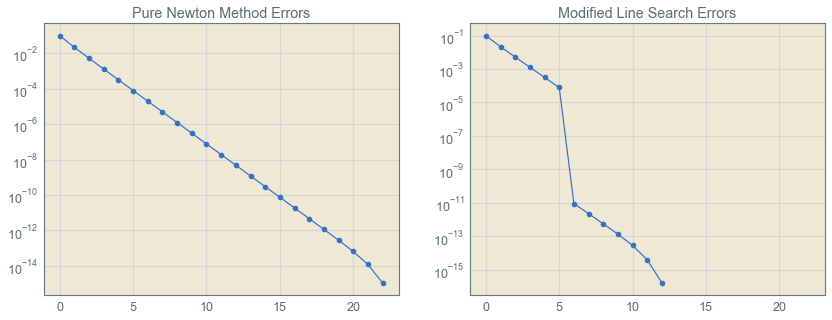

In [4]:
Ss = NewtonPoly(A)
Ms = NewtonPoly(A, cls="MLSearch", LS_iter = 6)
# ss = shf.SimpNewtonPoly(A)
# Ss = shf.NewtonPoly(A, X0 = np.array([[0, 1, 0],[0, 0, 1],[0, 0, 0]]))
# Ss = shf.NewtonPoly(A, X0 = 1 * np.eye(3))
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.semilogy(Ss['errs'],'-o')
ax1.set_title('Pure Newton Method Errors')

ax2.semilogy(Ms['errs'],'-o')
ax2.set_title('Modified Line Search Errors')
ax2.set_xlim(ax1.get_xlim())
# ax2.set_ylim(ax1.get_ylim())

print('Pure Calculate Time : {},  MLSearch Calculate Time : {}'.format(Ss['CalTime'], Ms['CalTime']))
print(Ss['sol'])
print(Ms['sol'])
# print(shf.Pnomial(Ss['sol'], A))